# Example Usage of EQTransformer from seisbench
This notebook is mostly an uncommented version of the “03a_training_phasenet” notebook from the seisbench repository.

In [1]:
import seisbench.generate as sbg

from seisbench.data import WaveformDataset
from seisbench.models import EQTransformer
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

Load the 100Samples dataset from the EQTransformer repository but transformed into seisbench-compatible format.

In [2]:
example_data = WaveformDataset("data/STEAD/example/seisbench")

Instantiate a version of seisbench’s EQTransformer

In [3]:
eqt = EQTransformer()

This part is slightly weird, but the *data* contains information about what is training, validation, and test, already.
In this case, I just randomly designated 81 samples as training data, 9 as dev/validation data, and the remaining 10 as test data; see also the “Convert Example Data to Seisbench Format” notebook.

In [4]:
train, dev, test = example_data.train_dev_test()

Rename the label columns.

In [5]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_s_arrival_sample": "S"
}

Perform (minimal) data augmentation.  I assume (but did not test) that `ChangeDtype` is necessary for the code to run; `ProbabilisticLabeller` provides the probability curves below, but I do not know how they are calculated.

In [6]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(train)

augmentations = [
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

Yay, fancy plots.

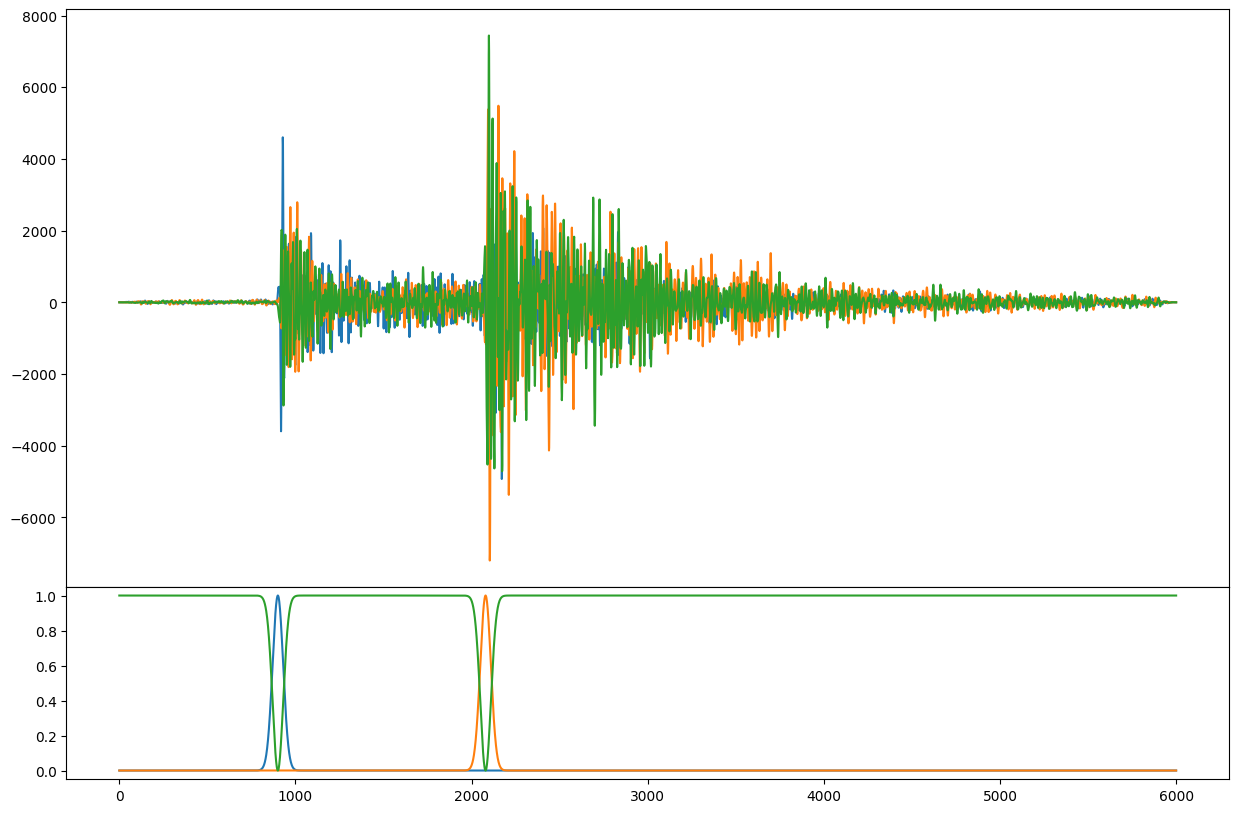

In [7]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

In [8]:
batch_size = 100 # 
num_workers = 1  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [9]:
learning_rate = 1e-2
epochs = 5

optimizer = torch.optim.Adam(eqt.parameters(), lr=learning_rate)

def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [10]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = eqt(batch["X"].to(eqt.device))

        # NOTE: pred, the output from eqt, is a 3-tuple; each element is a tensor with dimension (batch_size, sample_size)
        # I stack those three tensors so that the dimensions match up with batch["y"], ie, (batch_size, 3, sample_size) in this case
        pred = torch.stack(pred, dim = 1)
        
        loss = loss_fn(pred, batch["y"].to(eqt.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    eqt.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = eqt(batch["X"].to(eqt.device))
            
            # NOTE: Transform output from eqt; see comment above
            pred = torch.stack(pred, dim = 1)
            
            test_loss += loss_fn(pred, batch["y"].to(eqt.device)).item()

    eqt.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

Train the model.  Negative loss should not be possible, I think, but this could just be an issue with the small sample size.

In [11]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 0.754565  [    0/   81]
Test avg loss: 0.726965 

Epoch 2
-------------------------------
loss: 0.726510  [    0/   81]
Test avg loss: 0.257151 

Epoch 3
-------------------------------
loss: 0.202663  [    0/   81]
Test avg loss: 0.000109 

Epoch 4
-------------------------------
loss: 0.000088  [    0/   81]
Test avg loss: -0.000010 

Epoch 5
-------------------------------
loss: -0.000010  [    0/   81]
Test avg loss: -0.000010 



More fancy plots!

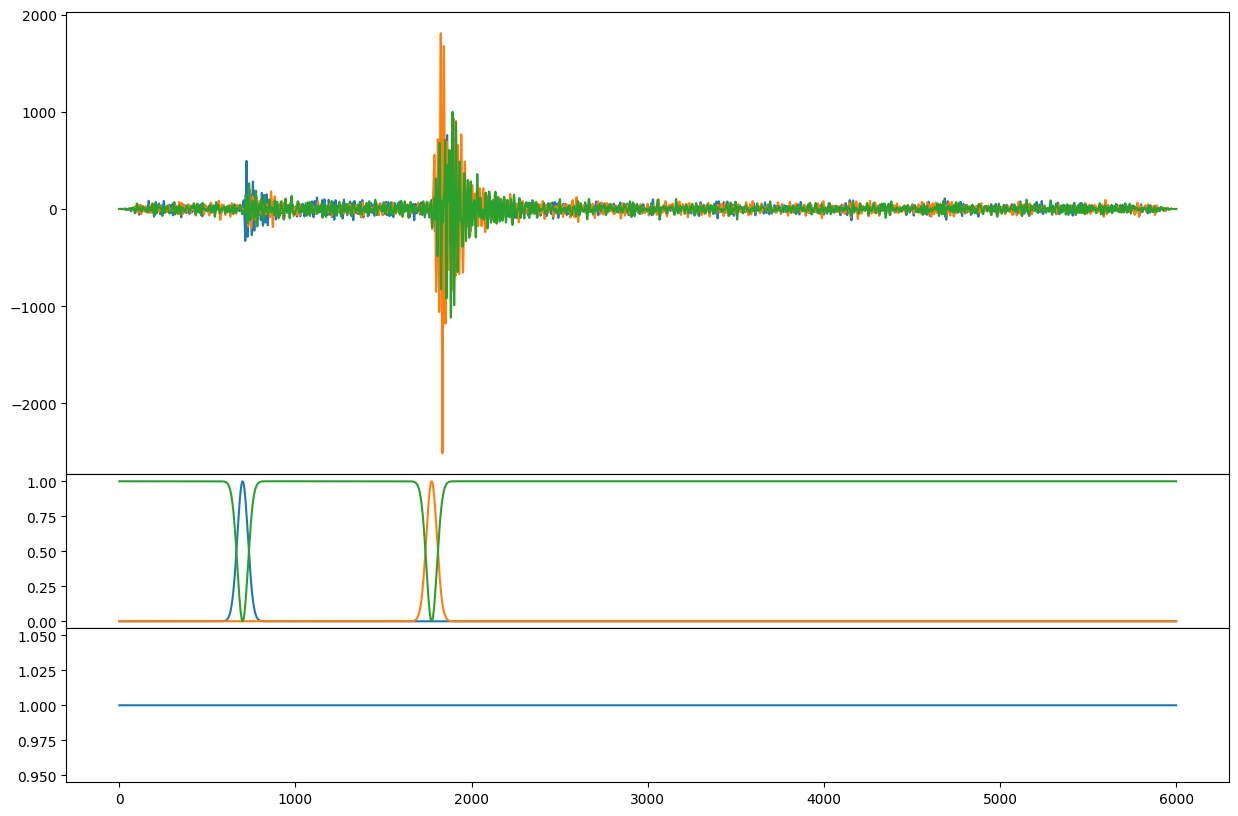

In [12]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

eqt.eval()  # close the model for evaluation

with torch.no_grad():
    pred = eqt(torch.tensor(sample["X"], device=eqt.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)